In [13]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from scipy.signal import savgol_filter as sg
from time_series_utils import WindowGen

In [14]:
cols= ['time','missing_info','job_id','task_index','machineid','event_type','user','sch_class',
       'priority','cpu_req','mem_req','disk_req','machine_restr']

n_files = 5
try:
    df = pd.read_csv(f'data_{n_files}.zip',index_col=0)
except:
    print('Loading new data...')
    data= pd.DataFrame()
    for i in range(n_files):
        try:
            df = pd.read_csv('data/'+sorted(os.listdir('data'))[i],names=cols)
            df[['job_id','task_index']] = df[['job_id','task_index']].astype(str)
            df['n_tasks'] = df['job_id']+df['task_index']
            df['slot']=df['time']//120000000
            df = df[['slot','n_tasks','cpu_req','mem_req']].drop_duplicates('n_tasks')
            df = df.groupby('slot',as_index=True).agg({"n_tasks": 'count',"cpu_req": np.sum,'mem_req': np.sum})
            data = pd.concat([data,df],axis=0)
        except:
            continue
    df = data.reset_index(drop=True)
    df.to_csv(f'data_{n_files}.zip')
    print('Data is loaded.')


In [9]:
# Data Transformations
df_proc = df
df_proc['n_tasks'] = np.log(df_proc['n_tasks'])

def norm(series):
    mean = series.mean()
    std = series.std()
    return (series-mean)/std

In [ ]:
# Split data into train and test sets
n_samples = inputs.shape[0]
split = 0.1

train_df = df_proc[:round(n_samples*(1-split))]
test_df = df_proc[:round(n_samples*(1-split))]

In [ ]:
train_df = train_df.apply(norm, axis=1)
test_df = test_df.apply(norm, axis=1)

In [4]:
# Reshape data according to a given window
step = 60
window = WindowGen(step)

X_train, y_train = window(train_df,columns_names=['n_tasks'],label_names=['n_tasks'])
X_test, y_test = window(test_df,columns_names=['n_tasks'],label_names=['n_tasks'])

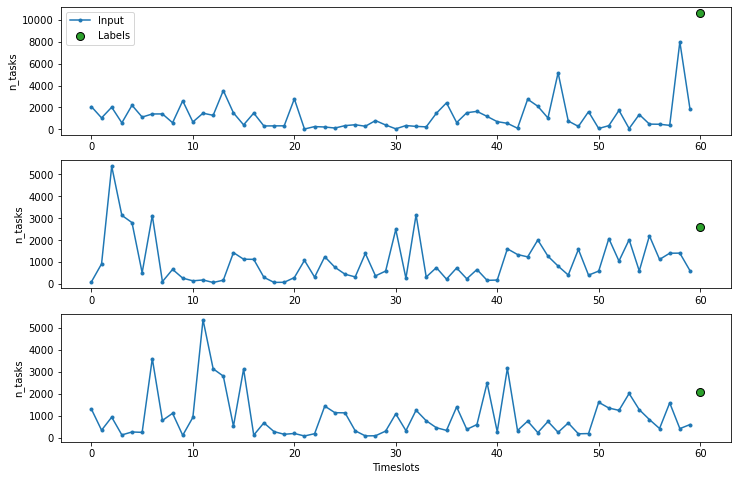

In [7]:
window.plot(plt_col='n_tasks')

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras import backend as K
import datetime
from tensorflow.keras import regularizers
import keras_tuner as kt
%load_ext tensorboard

In [ ]:
# Loss function
@tf.function
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square((y_pred) - (y_true))))

In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [ ]:
# Callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    './tmp/checkpoint',
    save_weights_only=True,
    monitor='loss',
    save_best_only=True)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# early_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,
#     patience=30)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each time step is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [ ]:
def model_builder(hp):
    model = tf.keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=32)
    model.add(tf.keras.layers.LSTM(units=hp_units))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

      # Tune the learning rate for the optimizer
      # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=root_mean_squared_error)

    return model

In [ ]:
class MyTuner(kt.tuners.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 1000, 3000, step=200)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

# Uses same arguments as the BayesianOptimization Tuner.
tuner = MyTuner(model_builder,
                     objective='loss',
                     max_trials = 100)
# Don't pass epochs or batch_size here, let the Tuner tune them.
tuner.search(x=X_train,y=y_train,callbacks=[model_checkpoint_callback,tensorboard_callback,early_callback]
             ,validation_data=(X_test,y_test))

In [ ]:
def bilstm():
    inp = tf.keras.Input(shape=(step,1))
    x = tf.keras.layers.LSTM(400)(inp)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs=[inp], outputs=x)
bilstm = bilstm()

In [ ]:
model = bilstm

In [ ]:
EPOCHS = 1000
BATCH = 2000
model.compile(loss=root_mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(3e-4))

if model==bilstm or model==lstm:
#     history = model.fit(x=X_train,y=y_train, epochs=EPOCHS, batch_size=BATCH,
#      callbacks=[model_checkpoint_callback,tensorboard_callback,early_callback],validation_data=(X_test,y_test))
    
else: # with sg-filter
    X_train_sg =  sg(X_train.reshape(-1,60),11,6).reshape(-1,60,1)
    X_test_sg =  sg(X_test.reshape(-1,60),11,6).reshape(-1,60,1)
    history = model.fit(x= X_train_sg,y=y_train, epochs=EPOCHS, batch_size=BATCH, shuffle= False,
                        callbacks=[model_checkpoint_callback],validation_data=(X_test_sg,y_test))

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
history = model.fit(x=X_train,y=y_train, epochs=EPOCHS, batch_size=BATCH,
      callbacks=[model_checkpoint_callback,tensorboard_callback,early_callback],validation_data=(X_test,y_test))

In [ ]:
model.load_weights('./tmp/checkpoint')

In [ ]:
fin = model.predict(X_train)

In [ ]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(fin,y_train)
print('Root mean squared loss is: ', m.result().numpy())

In [ ]:
y_train=y_train.reshape(-1)
y_test=y_test.reshape(-1)
fin= fin.reshape(-1)

m = tfa.metrics.r_square.RSquare()
m.update_state(fin, y_train)
print('R-squared is: ', m.result().numpy())

In [ ]:
fin

In [ ]:
y_train

In [ ]:
y_train_e=np.exp(y_train)
fin_e=np.exp(fin)

In [ ]:
y_pred = pd.DataFrame({'slot':[i for i in range(len(fin))],'Class':['Prediction' for i in range(len(fin))],'mem_req':fin_e})
y_true = pd.DataFrame({'slot':[i for i in range(len(fin))],'Class':['True' for i in range(len(fin))],'mem_req':y_train_e})
final = pd.concat([y_pred,y_true], axis=0)

In [ ]:
sns.lineplot(x='slot',y= 'mem_req', ci=None, 
             hue='Class', data=final.reset_index())